# Train FCN for semantic segmentation

You must only define model structure and choose loss function

After model will work, optionally add some augmentation to improve results

## Load the data

Dataset is a part of [midv500](https://arxiv.org/abs/1807.05786) dataset.
For a simplicity all quadrangles converted to png masks.



In [ ]:
! wget http://fmb.images.gan4x4.ru/hse/midv500p.zip
! unzip -q midv500p.zip

--2025-02-05 12:51:32--  http://fmb.images.gan4x4.ru/hse/midv500p.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9183651 (8.8M) [application/zip]
Saving to: ‘midv500p.zip’

midv500p.zip        100%[===================>]   8.76M  2.55MB/s    in 3.9s    

2025-02-05 12:51:37 (2.23 MB/s) - ‘midv500p.zip’ saved [9183651/9183651]



In [ ]:
!pip install wandb --upgrade --quiet
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 66.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import wandb

!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kivcich (kivcich-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# инициализируем проект
wandb.init(project="segmentation")

wandb: Currently logged in as: kivcich (kivcich-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Dataset.
You can use it without modification

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import optim
from torchvision import transforms
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch.utils.data import Dataset
from torchvision import tv_tensors
from PIL import Image, ImageFile
from torchvision.io import read_image
import glob

# To bypass error on corrupted files: https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images
# ImageFile.LOAD_TRUNCATED_IMAGES = False


class MaskDataset(Dataset):
    def __init__(
        self,
        train_part=True,
        transform=None,  # for image only
        transforms=None,  # for image and mask
        target_transform=None,  # for mask only
        path="midv500p",
    ):
        self.transform = transform
        self.transforms = transforms
        self.target_transform = target_transform
        path += "/train" if train_part else "/val"
        files = glob.glob(path + "/image/*")
        self.loaded_images = []
        self.loaded_masks = []

        for filename in files:  # cache all data in memory
            self.loaded_images.append(read_image(filename) / 255)
            mask_fn = filename.replace("image", "mask").replace("jpg", "png")
            self.loaded_masks.append(read_image(mask_fn) / 255)

    def __getitem__(self, i):
        img = self.loaded_images[i]
        mask = self.loaded_masks[i]
        if self.transform is not None:
            img = self.transform(img)
        if self.transforms is not None:
            img, mask = self.transforms(tv_tensors.Image(img), tv_tensors.Mask(mask))
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.loaded_images)

Dataloaders initialization

In [ ]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader


v2_transforms = v2.Compose(
    [
        v2.Resize((224, 224), antialias=True),  # antialias to suppress warning
        v2.ToDtype(torch.float32, scale=True),
    ]
)


trainset = MaskDataset(train_part=True, transforms=v2_transforms)
valset = MaskDataset(train_part=False, transforms=v2_transforms)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)


Lets show some data

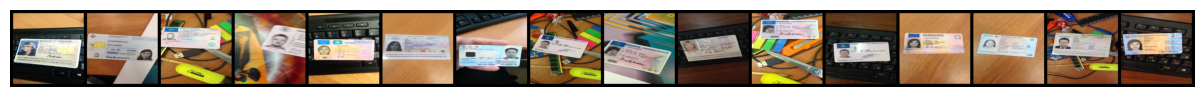

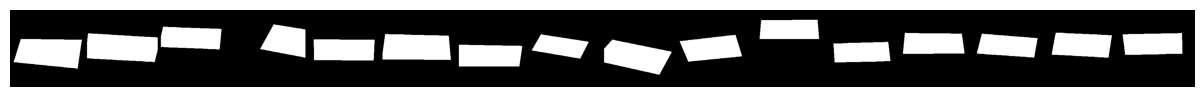

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose((img_grid * 255).numpy().astype(np.uint8), (1, 2, 0)))


images, masks = next(iter(train_loader))

show(images)
show(masks)

# Code for train

You must select Loss function

## Define your model structure here

Use [UNet](https://arxiv.org/pdf/1505.04597.pdf) - like structure.
But  decrease number of layers for simplicity.
Original images has 224x224 resolution.

In [ ]:
class MiniUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(MiniUnet, self).__init__()
        self.down1 = self.conv_block(in_channels, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.middle = self.conv_block(256, 512)

        self.up3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        #down
        dw1 = self.down1(x)
        dw2 = self.down2(self.pool(dw1))
        dw3 = self.down3(self.pool(dw2))

        #final
        middle = self.middle(self.pool(dw3))

        # Up
        up3 = self.up3(middle)
        dec3 = self.dec3(torch.cat([up3, dw3], dim=1))

        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, dw2], dim=1))

        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, dw1], dim=1))

        #exit
        return torch.sigmoid(self.final(dec1))

## Train the model

Select appopriate loss and metric


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=7, batch_size=8, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)

    for epoch in range(num_epochs):
        # режим тренировки
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]"):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)

            loss = criterion(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # режим валидации
        model.eval()

        val_loss = iou_score = 0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]"):
                images, masks = images.to(device), masks.to(device)

                preds = model(images)

                loss = criterion(preds, masks)
                val_loss += loss.item()

                # считаем IoU
                preds_bin = (preds > 0.5).float()
                intersection = (preds_bin * masks).sum(dim=[1, 2, 3])
                union = (preds_bin + masks).sum(dim=[1, 2, 3]) - intersection
                iou = (intersection / union).mean().item()
                iou_score += iou

        # логирование
        wandb.log(
            {
                "Training Loss": train_loss / len(train_loader),
                "Validation Loss": val_loss / len(val_loader),
                "IoU Score": iou_score / len(val_loader)
            }
        )

        print(f"\tTraining Loss: {train_loss / len(train_loader):.4f}")
        print(f"\tValidation Loss: {val_loss / len(val_loader):.4f}")
        print(f"\tIoU Score: {iou_score / len(val_loader):.4f}")

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss

mini_unet = MiniUnet()
wandb.watch(mini_unet)

optimizer = torch.optim.Adam(mini_unet.parameters(), lr=0.0001)
criterion = DiceLoss(mode="binary")

train(
    model=mini_unet,
    train_loader=train_loader, # тренировочный сэт
    val_loader=val_loader,  # валидационный сэт
    criterion=criterion,
    optimizer=optimizer# loss
)


Epoch 1/7 [Training]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/7 [Validation]:   0%|          | 0/16 [00:00<?, ?it/s]

	Training Loss: 0.6340
	Validation Loss: 0.6366
	IoU Score: 0.2535


Epoch 2/7 [Training]:   0%|          | 0/18 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8a0d9453a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8a0d9453a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Epoch 2/7 [Validation]:   0%|          | 0/16 [00:01<?, ?it/s]

^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


	Training Loss: 0.6228
	Validation Loss: 0.6207
	IoU Score: 0.2535


Epoch 3/7 [Training]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/7 [Validation]:   0%|          | 0/16 [00:00<?, ?it/s]

	Training Loss: 0.6127
	Validation Loss: 0.6086
	IoU Score: 0.2622


Epoch 4/7 [Training]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/7 [Validation]:   0%|          | 0/16 [00:00<?, ?it/s]

	Training Loss: 0.5924
	Validation Loss: 0.5867
	IoU Score: 0.6214


Epoch 5/7 [Training]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/7 [Validation]:   0%|          | 0/16 [00:00<?, ?it/s]

	Training Loss: 0.5664
	Validation Loss: 0.5672
	IoU Score: 0.7057


Epoch 6/7 [Training]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/7 [Validation]:   0%|          | 0/16 [00:00<?, ?it/s]

	Training Loss: 0.5603
	Validation Loss: 0.5668
	IoU Score: 0.7182


Epoch 7/7 [Training]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/7 [Validation]:   0%|          | 0/16 [00:00<?, ?it/s]

	Training Loss: 0.5635
	Validation Loss: 0.5665
	IoU Score: 0.7120


##Графики из wandb

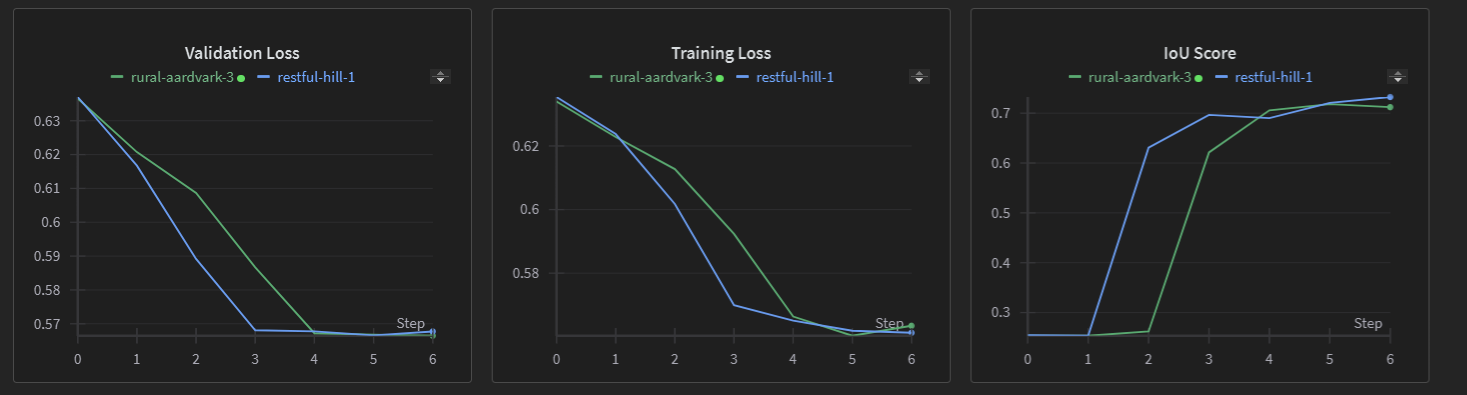

# Display results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def show_valset_pred(model, cols=16):
    model.to(device)
    images, pred_masks = [], []
    try:
        tmp = valset.transform
        valset.transform = None
        for batch in valset:
            with torch.no_grad():
                img, mask = batch
                images.append(img.unsqueeze(0))
                output = model(img.unsqueeze(0).to(device))
                pred_masks.append(output.cpu())

    finally:
        valset.transform = tmp
    show(torch.stack(images).squeeze()[:cols, ...])
    binary_mask = torch.stack(pred_masks) > 0.5
    show(binary_mask.squeeze(1).float()[:cols, ...])

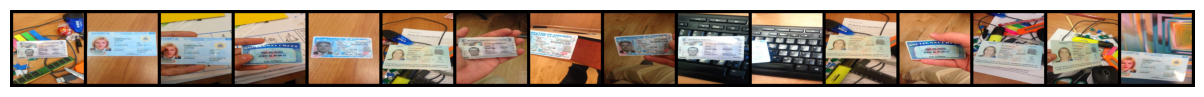

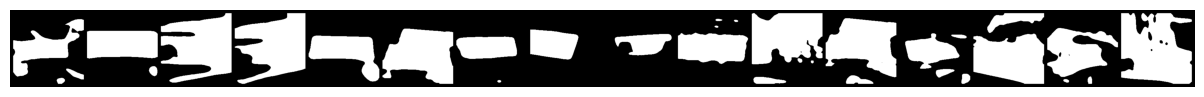

In [ ]:
show_valset_pred(mini_unet, 16)

# Conclusion

Получилось построить и обучить mini-Unet, хоть и работает данная модель не совсем идеально, но думаю для упрощенной модели вполне терпимо

#Ideas for extra work

* Build segmentation model using pretrained backbone model from [SMP](https://github.com/qubvel/segmentation_models.pytorch) and compare results with obtained from your model
* Combine two different loss e.g. BCE and [IoULoss](https://smp.readthedocs.io/en/latest/losses.html#jaccardloss)
* Add augmentation from [Albumentation](https://albumentations.ai/)